In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import linalg as la
import math as m

from src.optical_processing import optical_data_preprocessing, crop_videos_to_heart, downsample_videos, \
    get_vertices_without_nans, get_signals, get_connectivity, mean_std_norm

In [16]:
all_results = {}
all_results['P1'] = {}
all_results['P2'] = {}
for use_path_1 in [True, False]:
    for RG in [0, 10, 30, 50, 80]:
        optical_path = f'data/RG_analysis_data/09_04_18/RG{RG}_10s.pkl'

        with open(optical_path, 'rb') as f:
            data = pickle.load(f)
            videos = optical_data_preprocessing([data])
            videos = downsample_videos(videos, 1, 4)
            videos = crop_videos_to_heart(videos)
            videos = [mean_std_norm(video, axis=0) for video in videos]


        # get vertices, signals and connectivity structures
        all_vertices = get_vertices_without_nans(videos)  # list length S, elements (W'*D', 2), where W'*D' = N' = num nodes on surface
        conn = get_connectivity(all_vertices)[0]
        signal = get_signals(all_vertices, videos)[0]

        import torch

        from src.models.adaptive.AdaCGP_optical import AdaCGP
        from src.models.adaptive.TISO import TISO
        from src.models.adaptive.TIRSO import TIRSO

        def get_model(name):
            models = {
                'AdaCGP': AdaCGP,
                'TISO': TISO,
                'TIRSO': TIRSO
            }
            if name not in models:
                raise ValueError(f"Model {name} not implemented")
            return models[name]

        def get_ar_data(signal, P, device):
            X = []
            y = []
            for t in range(P, len(signal)):
                xPt = np.stack([signal[t - p] for p in range(1, P+1)], axis=0)
                yt = signal[t]
                X.append(xPt)
                y.append(yt)
                
            X = np.stack(X, axis=0)
            y = np.stack(y, axis=0)[:, :, None]
            return torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(y, dtype=torch.float32, device=device)

        hyperparams = {"P": 3,
                    "gamma": 1,
                    "w_stepsize": 1e-5,
                    "h_stepsize": 1e-5,
                    "psi_stepsize": 1e-5,
                    "epsilon": 1e-3,
                    "lambda": 0.5,
                    "nu": 0.01,
                    "ma_alpha": 0.005,
                    "use_path_1": use_path_1,
                    "instant_h": True,
                    "patience": 100,
                    "burn_in_debiasing": 500,
                    "min_delta_percent": 0.01,
                    "use_armijo": True,
                    "warm_up_steps": 0,
                    "alternate": False,### this is actually used in AdaCGP_optical
                    "alternate_mod": 2,
                    "monitor_debiasing": 'pred_error_recursive_moving_average_h',
                    "mus": [0.1, 0.1, 0.1],
                    "store_all_matrices": True,
                    "project_to_weight_matrix": True
        }
        device = 'cpu'
        X, y = get_ar_data(signal, hyperparams['P'], device)
        model = get_model('AdaCGP')(signal.shape[1], hyperparams, device)

        # Run optimization
        model_inputs = {
            'X': X,
            'y': y,
            'weight_matrix': torch.tensor(conn, dtype=torch.float32, device=device),
        }

        fname = optical_path.split('/')[-1].split('.')[0]
        fpath = '/'.join(optical_path.split('/')[:-1])
        fsave_name = f"{fpath}/{fname}_results_lambda_{hyperparams['lambda']}_alternating_debias{hyperparams['alternate']}_use_path1_{hyperparams['use_path_1']}.pkl"

        try:
            with open(fsave_name, 'rb') as f:
                results = pickle.load(f)
        except FileNotFoundError:
            results = model.run(**model_inputs)
            with open(fsave_name, 'wb') as f:
                pickle.dump(results, f)

        results['signal'] = signal
        results['vertices'] = all_vertices[0]
        all_results['P1' if use_path_1 else 'P2'][RG] = results

/home/ajenkins/Projects/Adaptive/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))
/home/ajenkins/Projects/Adaptive/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))


In [33]:
all_results['P1'][0].keys()

dict_keys(['pred_error', 'pred_error_from_h', 'filter_error', 'w_error', 'coeff_errors', 'first_alg_converged_status', 'second_alg_converged_status', 'matrices', 'p_miss', 'p_false_alarm', 'psi_losses', 'percentage_correct_elements', 'num_non_zero_elements', 'prob_miss', 'prob_false_alarm', 'pred_error_recursive_moving_average', 'pred_error_recursive_moving_average_h', 'signal', 'vertices'])

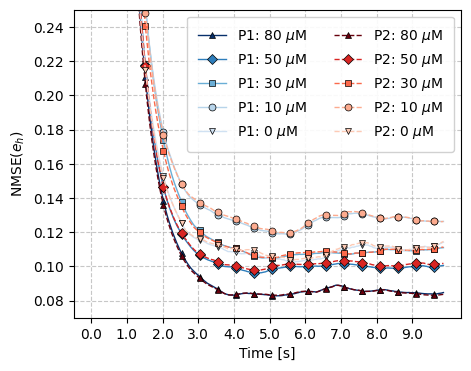

In [67]:
T_max = 3900

# Create two separate colormaps for P1 and P2
cmap_p2 = plt.get_cmap('Reds')
cmap_p1 = plt.get_cmap('Blues')

fig = plt.figure(figsize=(5, 4))
# Plot P1 data (reds)
for i, RG in enumerate([80, 50, 30, 10, 0]):
    results = all_results['P1'][RG]
    lcolor = cmap_p1((RG+20) / 100)
    y_error = np.array(results['pred_error_recursive_moving_average_h'])
    y_error_ma = [1]
    for i in range(1, len(y_error)):
        ma_t = 0.01 * y_error[i] + (1 - 0.01) * y_error_ma[-1]
        y_error_ma.append(ma_t)
    y_error_ma = np.array(y_error_ma)

    if RG == 0:
        lmarker = 'v'
        lstyle = '-'
    elif RG == 10:
        lmarker = 'o'
        lstyle = '-'
    elif RG == 30:
        lmarker = 's'
        lstyle = '-'
    elif RG == 50:
        lmarker = 'D'
        lstyle = '-'
    elif RG == 80:
        lmarker = '^'
        lstyle = '-'
    
    plt.plot(y_error_ma[:T_max], label=f"P1: {RG} $\mu$M", color=lcolor, marker=lmarker, markevery=200, markersize=5, markeredgecolor='black', markeredgewidth=0.5, linewidth=1, alpha=1, linestyle=lstyle)

# Now plot P2 data (blues)
for i, RG in enumerate([80, 50, 30, 10, 0]):
    results = all_results['P2'][RG]
    lcolor = cmap_p2((RG+20) / 100)
    y_error = np.array(results['pred_error_recursive_moving_average_h'])
    y_error_ma = [1]
    for i in range(1, len(y_error)):
        ma_t = 0.01 * y_error[i] + (1 - 0.01) * y_error_ma[-1]
        y_error_ma.append(ma_t)
    y_error_ma = np.array(y_error_ma)

    if RG == 0:
        lmarker = 'v'
        lstyle = '--'
    elif RG == 10:
        lmarker = 'o'
        lstyle = '--'
    elif RG == 30:
        lmarker = 's'
        lstyle = '--'
    elif RG == 50:
        lmarker = 'D'
        lstyle = '--'
    elif RG == 80:
        lmarker = '^'
        lstyle = '--'
    
    plt.plot(y_error_ma[:T_max], label=f"P2: {RG} $\mu$M", color=lcolor, marker=lmarker, markevery=200, markersize=5, markeredgecolor='black', markeredgewidth=0.5, linewidth=1, alpha=1, linestyle=lstyle)

# Create a more elegant legend with two columns
leg = plt.legend(ncol=2, loc='best', frameon=True, fancybox=True, 
                 framealpha=0.9, borderpad=0.8)
plt.xlabel('Time [s]')
plt.ylabel('NMSE(${e_h}$)')
plt.ylim(0.07, 0.25)
# plt.yscale('log')
# convert x scale to seconds where each 1 second == 395 iterations
plt.xticks(np.arange(0, T_max, 395), np.arange(0, T_max/395))
plt.grid(True, linestyle='--', alpha=0.7)
# save as svg file in figures
plt.savefig('figures/09_04_18_optical_convergence_vs_RGdose.svg')
plt.show()

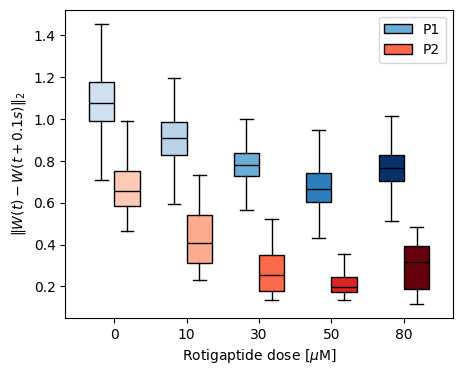

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_edge_stability(Ws_steady_RG, window=40):
    return np.array([np.linalg.norm(Ws_steady_RG[i] - Ws_steady_RG[i+window])
                     for i in range(len(Ws_steady_RG) - window)])

def plot_edge_stability(all_results, window=400):
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Create separate colormaps for P1 and P2
    cmap_p1 = plt.get_cmap('Blues')
    cmap_p2 = plt.get_cmap('Reds')

    rotigaptide_doses = [0, 10, 30, 50, 80]
    
    # Calculate positions for side-by-side boxplots
    positions = np.arange(len(rotigaptide_doses))
    width = 0.35
    
    box_data_p1 = []
    box_data_p2 = []

    # Process P1 data
    for RG in rotigaptide_doses:
        results = all_results['P1'][RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        edge_stability = calculate_edge_stability(Ws_steady_RG, window=window)
        box_data_p1.append(edge_stability)

    # Process P2 data
    for RG in rotigaptide_doses:
        results = all_results['P2'][RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        edge_stability = calculate_edge_stability(Ws_steady_RG, window=window)
        box_data_p2.append(edge_stability)

    # Styling properties for boxplots
    box_props = dict(linewidth=1, edgecolor='black')
    whisker_props = dict(linewidth=1)
    median_props = dict(linewidth=1, color='black')

    # Plot P1 boxplots (red)
    bp1 = ax.boxplot(box_data_p1, positions=positions-width/2, widths=width, patch_artist=True,
                   boxprops=box_props, whiskerprops=whisker_props, medianprops=median_props,
                   showfliers=False)

    # Plot P2 boxplots (blue)
    bp2 = ax.boxplot(box_data_p2, positions=positions+width/2, widths=width, patch_artist=True,
                   boxprops=box_props, whiskerprops=whisker_props, medianprops=median_props,
                   showfliers=False)

    # Color the boxplots
    for patch, RG in zip(bp1['boxes'], rotigaptide_doses):
        patch.set_facecolor(cmap_p1((RG+20) / 100))
        
    for patch, RG in zip(bp2['boxes'], rotigaptide_doses):
        patch.set_facecolor(cmap_p2((RG+20) / 100))

    # Set axis labels
    ax.set_xlabel('Rotigaptide dose [$\mu$M]')
    ax.set_ylabel('$\Vert W(t) - W(t+0.1s) \Vert_2$')
    
    # Add grid
    # ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-tick positions and labels
    ax.set_xticks(positions)
    ax.set_xticklabels(rotigaptide_doses)
    
    # Create simple legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=cmap_p1(0.5), edgecolor='black', label='P1'),
        Patch(facecolor=cmap_p2(0.5), edgecolor='black', label='P2')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.savefig('figures/09_04_18_optical_edge_stability_vs_RGdose.svg')
    plt.show()

# Assuming all_results is defined
plot_edge_stability(all_results)

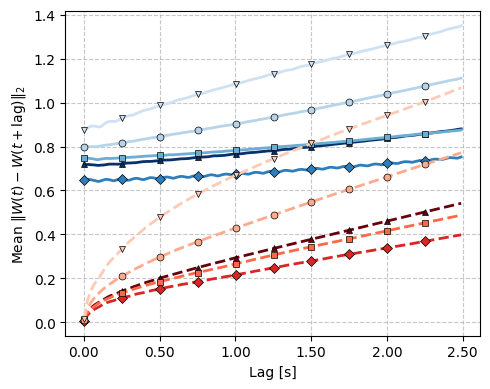

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_edge_stability_for_lags(Ws_steady_RG, max_lag=100):
    lags = range(1, min(max_lag + 1, len(Ws_steady_RG)), 5)
    stability = []
    for lag in lags:
        stability.append(np.mean([np.linalg.norm(Ws_steady_RG[j] - Ws_steady_RG[j+lag])
                                  for j in range(len(Ws_steady_RG) - lag)]))
    return lags, np.array(stability)

def plot_l2_norm_vs_lag(all_results, in_node=100, max_lag=100):
    fig, ax = plt.subplots(figsize=(5, 4))
    cmap_p1 = plt.get_cmap('Blues')
    cmap_p2 = plt.get_cmap('Reds')

    rotigaptide_doses = [80, 50, 30, 10, 0]
    
    # Define markers and styles
    markers = {0: 'v', 10: 'o', 30: 's', 50: 'D', 80: '^'}

    # Plot P1 data
    for i, RG in enumerate(rotigaptide_doses):
        results = all_results['P1'][RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        
        lags, avg_stability = calculate_edge_stability_for_lags(Ws_steady_RG, max_lag)
        
        color = cmap_p1((RG+20) / 100)
        lmarker = markers[RG]
        
        ax.plot(lags, avg_stability, color=color, label=f'P1: {RG} $\mu$M', 
                marker=lmarker, markevery=20, markersize=5, 
                markeredgecolor='black', markeredgewidth=0.5, 
                linewidth=2, alpha=1, linestyle='-')
    
    # Plot P2 data
    for i, RG in enumerate(rotigaptide_doses):
        results = all_results['P2'][RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        
        lags, avg_stability = calculate_edge_stability_for_lags(Ws_steady_RG, max_lag)
        
        color = cmap_p2((RG+20) / 100)
        lmarker = markers[RG]

        ax.plot(lags, avg_stability, color=color, label=f'P2: {RG} $\mu$M', 
                marker=lmarker, markevery=20, markersize=5, 
                markeredgecolor='black', markeredgewidth=0.5, 
                linewidth=2, alpha=1, linestyle='--')

    ax.set_xlabel('Lag [s]')
    ax.set_ylabel('Mean $\Vert W(t) - W(t+\mathrm{lag}) \Vert_2$')

    # Create a more elegant legend with two columns
    # leg = ax.legend(ncol=2, loc='best', frameon=True, fancybox=True, 
    #              framealpha=0.9, borderpad=0.8, title='Protocol-Dosage')
    leg.get_title().set_fontweight('bold')
    
    ax.grid(True, linestyle='--', alpha=0.7)

    time_per_lag = 0.25 / 100  # approx
    xtick_positions = ax.get_xticks()
    xtick_positions = [pos for pos in xtick_positions if pos >= 0 and pos <= max_lag]
    time_labels = [f'{pos * time_per_lag:.2f}' for pos in xtick_positions]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(time_labels)

    # log y scale
    # ax.set_yscale('log')

    plt.savefig('figures/09_04_18_optical_avg_edge_stability_vs_lag.svg', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Assuming all_results is defined
plot_l2_norm_vs_lag(all_results, max_lag=1000)

/tmp/ipykernel_1362314/2993288808.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved comparison figure to figures/RG_mp4/comparison_t1000.png


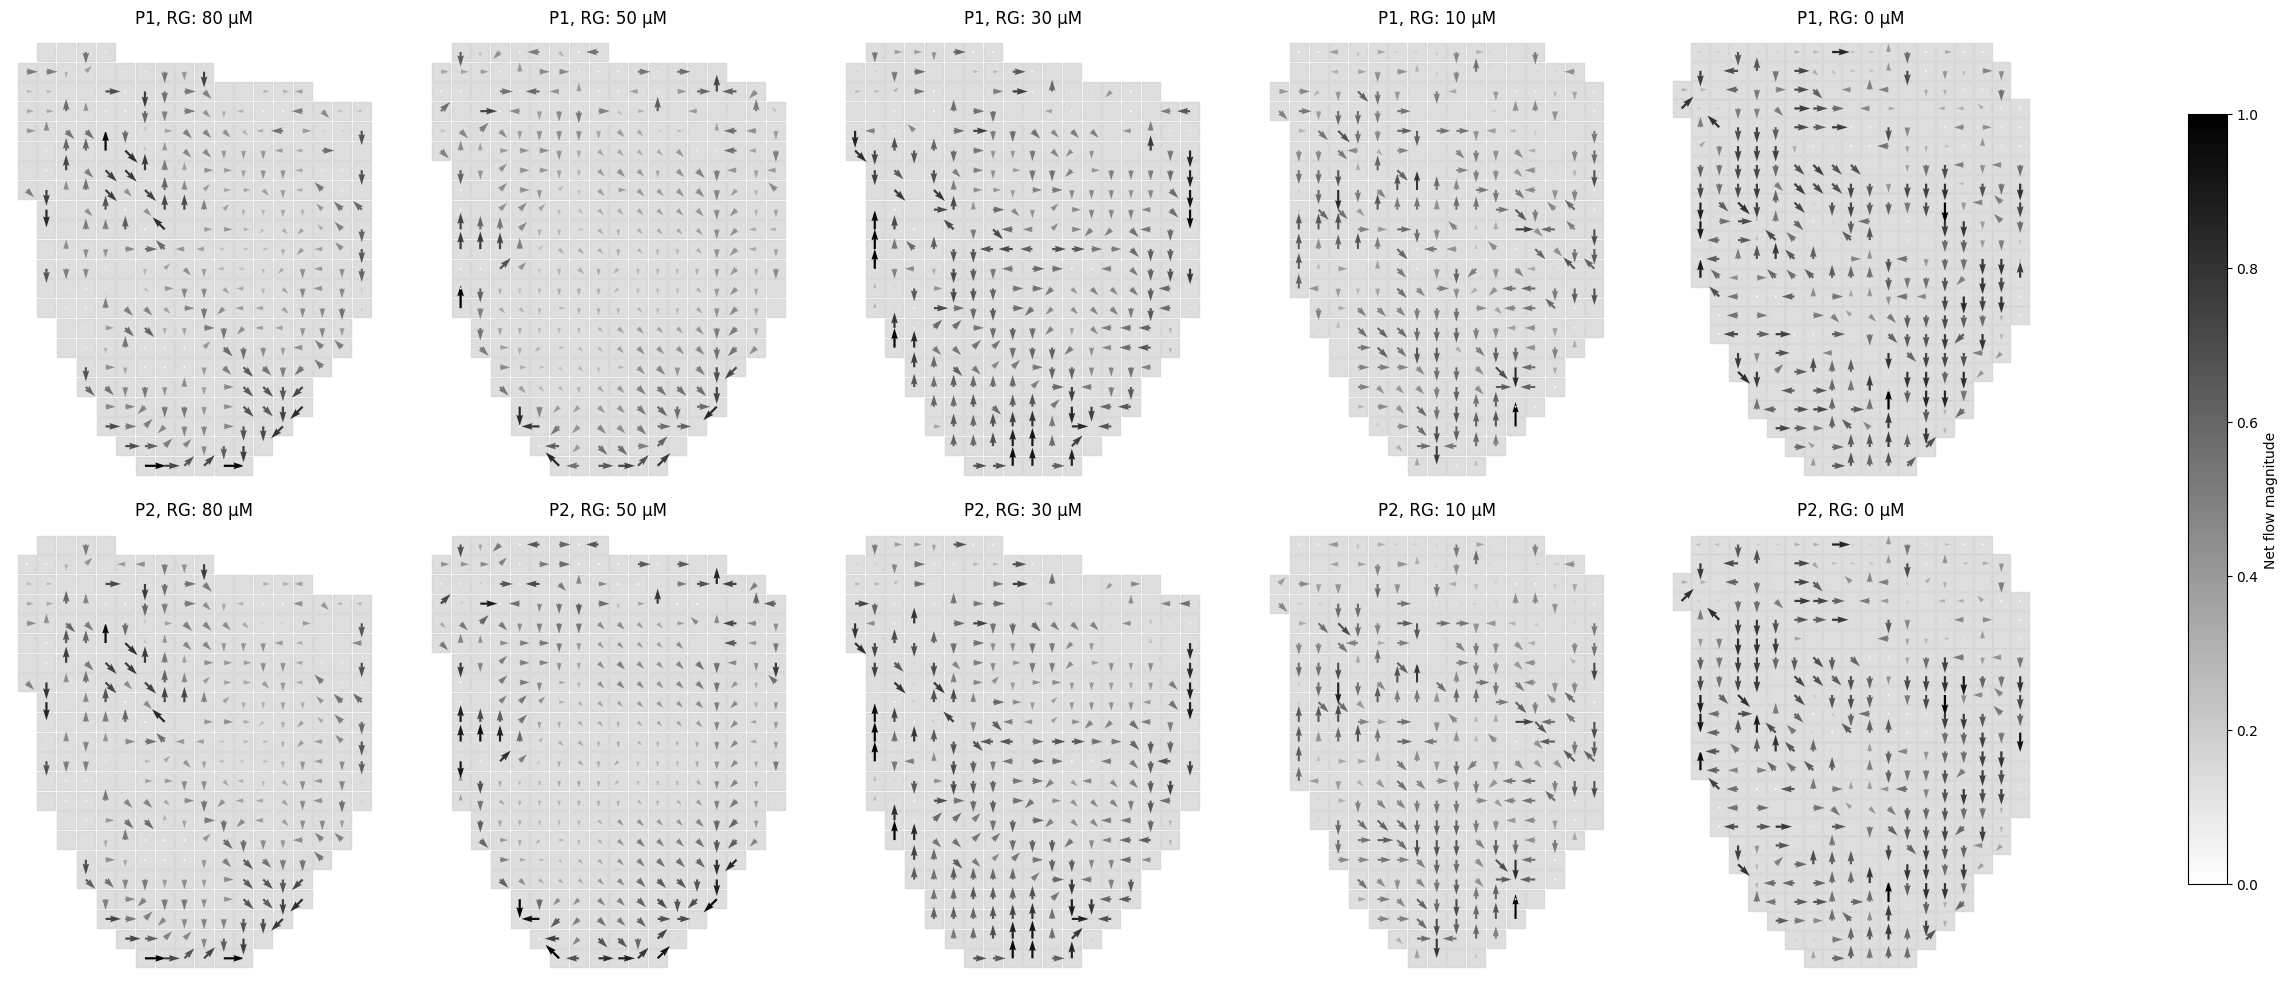

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

def compute_net_flow(W, verts):
    n = W.shape[0]
    net_flow = np.zeros((n, 2))
    
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                if i != j:
                    direction = verts[j] - verts[i]
                    direction /= np.linalg.norm(direction)
                    net_flow[i] += direction * (W[i, j] - W[j, i])
        
    return net_flow

def plot_net_edge_flow(all_results, protocol='P1', t=1000, figsize=(25, 5), save_dir=None):
    """
    Plot the net edge flow for a specific protocol.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    protocol : str, default='P1'
        Protocol to visualize, either 'P1' or 'P2'
    t : int, default=1000
        Timestep to visualize
    figsize : tuple, default=(25, 5)
        Figure size
    save_dir : str, default=None
        Directory to save the figure, if None the figure is not saved
    """
    fig, axes = plt.subplots(1, 6, figsize=figsize)
    axes = axes.flatten()

    # Check if valid protocol
    if protocol not in ['P1', 'P2']:
        raise ValueError("Protocol must be either 'P1' or 'P2'")
    
    # Select protocol-specific results
    protocol_results = all_results[protocol]

    rotigaptide_doses = [80, 50, 30, 10, 0]
    cmap = plt.cm.binary

    for idx, RG in enumerate(rotigaptide_doses):
        ax = axes[idx]
        results = protocol_results[RG]
        verts = results['vertices'].astype(float)
        signal = results['signal']
        W = results['matrices'][t]

        # Remove self-loops and keep only the strongest edge for each node
        np.fill_diagonal(W, 0)
        W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

        # Compute net flow
        net_flow = compute_net_flow(W, verts)
        
        # Normalize net flow for better visualization
        net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
        max_magnitude = np.max(net_flow_magnitude)
        net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

        # Create quiver plot
        ax.scatter(verts[:, 0], verts[:, 1], c='lightgray', s=160, marker='s', alpha=.75)
        ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                  net_flow_magnitude, cmap=cmap, scale=14, width=0.006)

        # Plot settings
        ax.set_aspect('equal')
        ax.set_title(f'{protocol}, RG: {RG} µM')
        ax.axis('off')

    # Add colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[-1], label='Net flow magnitude')

    # Remove the last (empty) subplot
    fig.delaxes(axes[-1])
    plt.tight_layout()
    
    if save_dir is not None:
        # Create filename with protocol info
        filename = os.path.join(save_dir, f'{protocol}_t{t}.png')
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved figure to {filename}")
    
    plt.show()
    plt.close()

# Example usage:
# save_dir = 'figures/RG_mp4'
# os.makedirs(save_dir, exist_ok=True)

# min_t = min([len(all_results['P1'][RG]['first_alg_converged_status']) for RG in [0, 10, 30, 50, 80]])
# t = 1000

# # Plot for P1
# plot_net_edge_flow(all_results, protocol='P1', t=t, save_dir=save_dir)

# # Plot for P2
# plot_net_edge_flow(all_results, protocol='P2', t=t, save_dir=save_dir)

# Function to plot both protocols for comparison
def plot_both_protocols(all_results, t=1000, figsize=(25, 10), save_dir=None):
    """
    Plot both P1 and P2 protocols for comparison
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    t : int, default=1000
        Timestep to visualize
    figsize : tuple, default=(25, 10)
        Figure size
    save_dir : str, default=None
        Directory to save the figure, if None the figure is not saved
    """
    fig, axes = plt.subplots(2, 6, figsize=figsize)
    
    rotigaptide_doses = [80, 50, 30, 10, 0]
    cmap = plt.cm.binary
    
    # Common colorbar normalization
    all_magnitudes = []
    for protocol in ['P1', 'P2']:
        for RG in rotigaptide_doses:
            results = all_results[protocol][RG]
            verts = results['vertices'].astype(float)
            W = results['matrices'][t]
            np.fill_diagonal(W, 0)
            W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)
            net_flow = compute_net_flow(W, verts)
            net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
            all_magnitudes.extend(net_flow_magnitude)
    
    max_magnitude = np.max(all_magnitudes) if all_magnitudes else 1
    
    # Plot each protocol
    for row, protocol in enumerate(['P1', 'P2']):
        for idx, RG in enumerate(rotigaptide_doses):
            ax = axes[row, idx]
            results = all_results[protocol][RG]
            verts = results['vertices'].astype(float)
            W = results['matrices'][t]

            # Remove self-loops and keep only the strongest edge for each node
            np.fill_diagonal(W, 0)
            W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

            # Compute net flow
            net_flow = compute_net_flow(W, verts)
            
            # Normalize net flow for better visualization
            net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
            net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

            # Create quiver plot
            ax.scatter(verts[:, 0], verts[:, 1], c='lightgray', s=160, marker='s', alpha=.75)
            ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                     net_flow_magnitude, cmap=cmap, scale=14, width=0.006)

            # Plot settings
            ax.set_aspect('equal')
            ax.set_title(f'{protocol}, RG: {RG} µM')
            ax.axis('off')
    
    # Add colorbar to the rightmost column
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[:, -1], label='Net flow magnitude')

    # Remove the last (empty) subplots
    fig.delaxes(axes[0, -1])
    fig.delaxes(axes[1, -1])
    
    plt.tight_layout()
    
    if save_dir is not None:
        filename = os.path.join(save_dir, f'comparison_t{t}.png')
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved comparison figure to {filename}")
    
    plt.show()
    plt.close()

# Example usage:
plot_both_protocols(all_results, t=1000, save_dir='figures/RG_mp4')

Saved figure to figures/RG_two_timepoints/P1_net_flow_comparison.svg


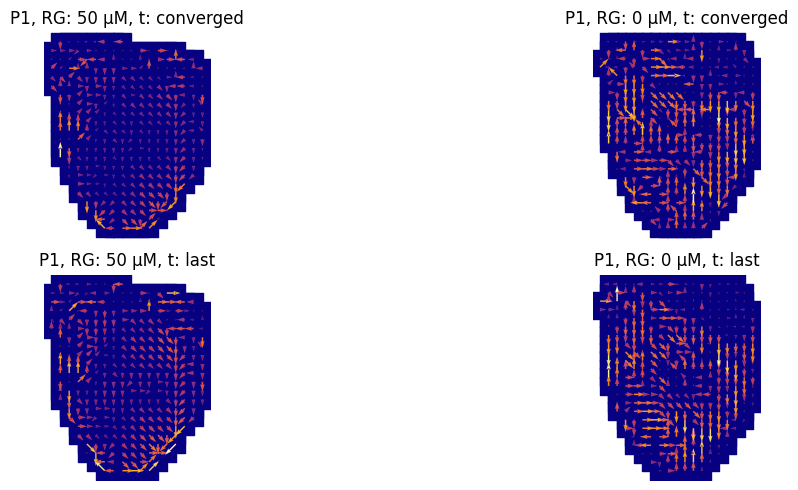

Saved figure to figures/RG_two_timepoints/P2_net_flow_comparison.svg


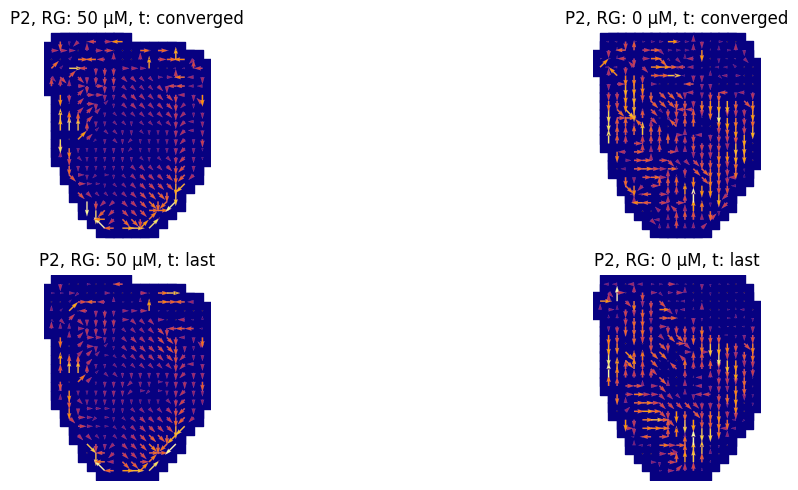

Saved comparison figure to figures/RG_two_timepoints/both_protocols_net_flow_comparison.svg


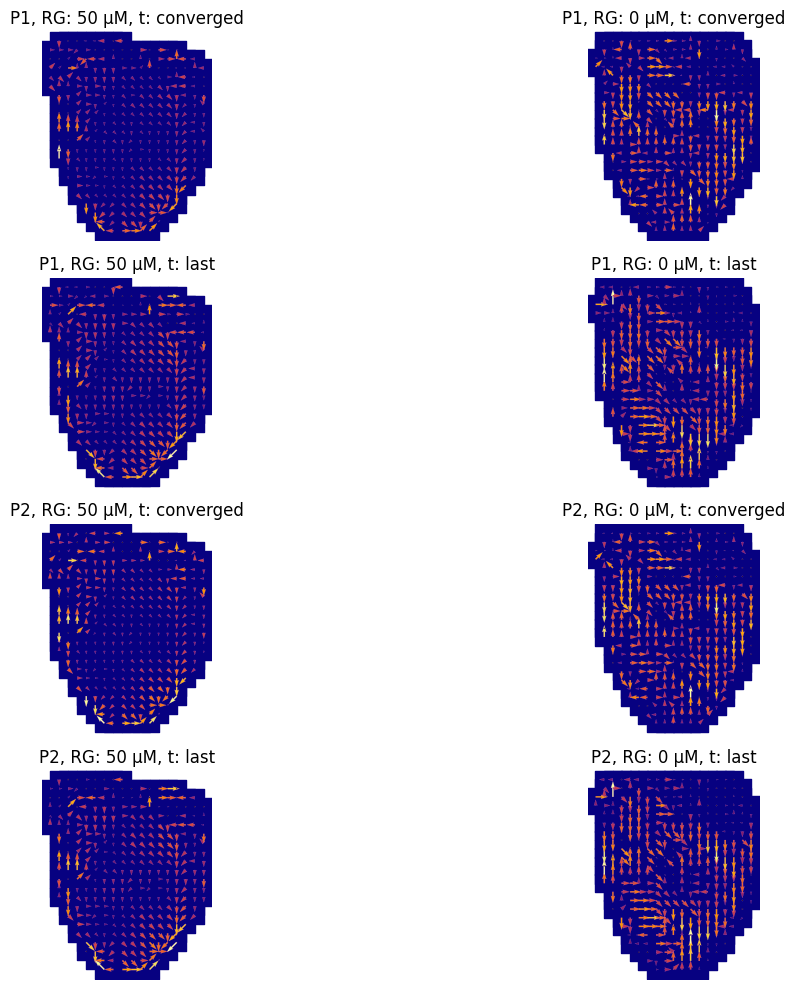

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_net_flow(W, verts):
    n = W.shape[0]
    net_flow = np.zeros((n, 2))
    
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                if i != j:
                    direction = verts[j] - verts[i]
                    direction /= np.linalg.norm(direction)
                    net_flow[i] += direction * (W[i, j] - W[j, i])
        
    return net_flow

def plot_net_edge_flow_two_timepoints(all_results, protocol='P1', figsize=(15, 5), save_dir=None):
    """
    Plot the net edge flow at two time points (convergence and last) for a specific protocol.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    protocol : str, default='P1'
        Protocol to visualize, either 'P1' or 'P2'
    figsize : tuple, default=(15, 5)
        Figure size
    save_dir : str, default=None
        Directory to save the figure, if None the figure is not saved
    """
    # Check if valid protocol
    if protocol not in ['P1', 'P2']:
        raise ValueError("Protocol must be either 'P1' or 'P2'")
        
    # Select protocol-specific results
    protocol_results = all_results[protocol]
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    rotigaptide_doses = [50, 0]
    cmap = plt.cm.inferno

    for idx, RG in enumerate(rotigaptide_doses):
        results = protocol_results[RG]
        verts = results['vertices'].astype(float)
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = results['matrices']

        # Find the index of the first True value in first_alg_converged_status
        t_converged = np.argmax(first_alg_converged_status)
        
        # Get the last matrix
        t_last = len(matrices) - 1

        for row, t in enumerate([t_converged, t_last]):
            ax = axes[row, idx]
            W = matrices[t]

            # Remove self-loops and keep only the strongest edge for each node
            np.fill_diagonal(W, 0)
            W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

            # Compute net flow
            net_flow = compute_net_flow(W, verts)
            
            # Normalize net flow for better visualization
            net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
            max_magnitude = np.max(net_flow_magnitude)
            net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

            # Create quiver plot
            ax.scatter(verts[:, 0], verts[:, 1], c='#070181', s=160, marker='s', alpha=1)
            ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                      net_flow_magnitude, cmap=cmap, scale=11, width=0.008, edgecolors='orchid', linewidths=0.1)

            # Plot settings
            ax.set_aspect('equal')
            ax.set_title(f'{protocol}, RG: {RG} µM, t: {"converged" if row == 0 else "last"}')
            ax.axis('off')

    # Add colorbar
    # fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[:, -1], label='Net flow magnitude')

    plt.tight_layout()
    if save_dir is not None:
        # Create filename with protocol info
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, f'{protocol}_net_flow_comparison.svg')
        else:
            # Add protocol prefix to the filename
            dirname = os.path.dirname(save_dir)
            basename = os.path.basename(save_dir)
            filename = os.path.join(dirname, f'{protocol}_{basename}')
        
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved figure to {filename}")
    
    plt.show()
    plt.close()

def plot_both_protocols_two_timepoints(all_results, figsize=(15, 10), save_dir=None):
    """
    Plot the net edge flow at two time points for both P1 and P2 protocols.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    figsize : tuple, default=(15, 10)
        Figure size
    save_dir : str, default=None
        Directory to save the figure, if None the figure is not saved
    """
    fig, axes = plt.subplots(4, 2, figsize=figsize)

    rotigaptide_doses = [50, 0]
    cmap = plt.cm.inferno
    
    # Common colorbar normalization
    all_magnitudes = []
    for protocol_idx, protocol in enumerate(['P1', 'P2']):
        for RG in rotigaptide_doses:
            results = all_results[protocol][RG]
            verts = results['vertices'].astype(float)
            first_alg_converged_status = results['first_alg_converged_status']
            matrices = results['matrices']
            
            # Time points
            t_converged = np.argmax(first_alg_converged_status)
            t_last = len(matrices) - 1
            
            for t in [t_converged, t_last]:
                W = matrices[t]
                np.fill_diagonal(W, 0)
                W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)
                net_flow = compute_net_flow(W, verts)
                net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
                all_magnitudes.extend(net_flow_magnitude)
    
    max_magnitude = np.max(all_magnitudes) if all_magnitudes else 1

    # Plot each protocol
    for protocol_idx, protocol in enumerate(['P1', 'P2']):
        for idx, RG in enumerate(rotigaptide_doses):
            results = all_results[protocol][RG]
            verts = results['vertices'].astype(float)
            first_alg_converged_status = results['first_alg_converged_status']
            matrices = results['matrices']

            # Find the index of the first True value in first_alg_converged_status
            t_converged = np.argmax(first_alg_converged_status)
            
            # Get the last matrix
            t_last = len(matrices) - 1

            for time_idx, t in enumerate([t_converged, t_last]):
                # Calculate row position in the 4x5 grid
                row = protocol_idx * 2 + time_idx
                ax = axes[row, idx]
                
                W = matrices[t]

                # Remove self-loops and keep only the strongest edge for each node
                np.fill_diagonal(W, 0)
                W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

                # Compute net flow
                net_flow = compute_net_flow(W, verts)
                
                # Normalize net flow using common max_magnitude
                net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
                net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

                # Create quiver plot
                ax.scatter(verts[:, 0], verts[:, 1], c='#070181', s=160, marker='s', alpha=1)
                ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                         net_flow_magnitude, cmap=cmap, scale=11, width=0.008, edgecolors='orchid', linewidths=0.1)

                # Plot settings
                ax.set_aspect('equal')
                time_label = "converged" if time_idx == 0 else "last"
                ax.set_title(f'{protocol}, RG: {RG} µM, t: {time_label}')
                ax.axis('off')

    plt.tight_layout()
    if save_dir is not None:
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, f'both_protocols_net_flow_comparison.svg')
        else:
            # Add 'both_' prefix to the filename
            dirname = os.path.dirname(save_dir)
            basename = os.path.basename(save_dir)
            filename = os.path.join(dirname, f'both_protocols_{basename}')
            
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved comparison figure to {filename}")
        
    plt.show()
    plt.close()

# Usage examples:
save_dir = 'figures/RG_two_timepoints'
os.makedirs(save_dir, exist_ok=True)

# For a single protocol:
plot_net_edge_flow_two_timepoints(all_results, protocol='P1', save_dir=save_dir)
plot_net_edge_flow_two_timepoints(all_results, protocol='P2', save_dir=save_dir)

# For both protocols in a single figure:
plot_both_protocols_two_timepoints(all_results, save_dir=save_dir)

Saved node location figure to figures/node_in_out_analysis/P1_RG0_node220_location.svg


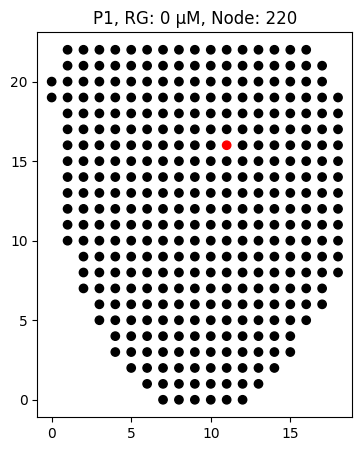

Saved in-out degree figure to figures/node_in_out_analysis/P1_RG0_node220_in_out_degree.svg


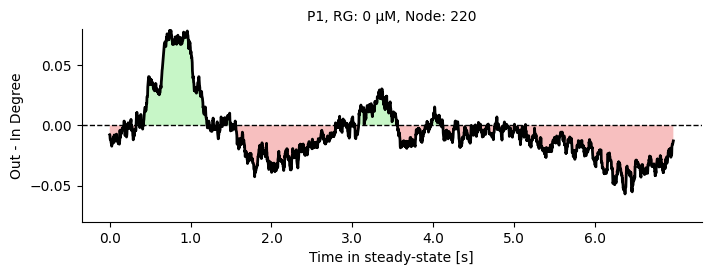

Saved node location figure to figures/node_in_out_analysis/P2_RG0_node220_location.svg


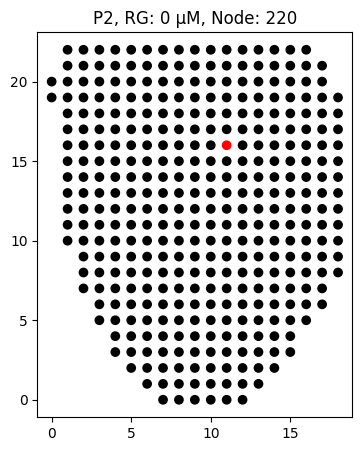

Saved in-out degree figure to figures/node_in_out_analysis/P2_RG0_node220_in_out_degree.svg


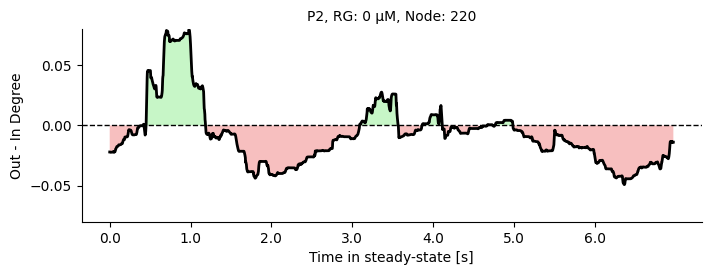

Saved comparison figure to figures/node_in_out_analysis/compare_P1_P2_RG0_node220_in_out_degree.svg


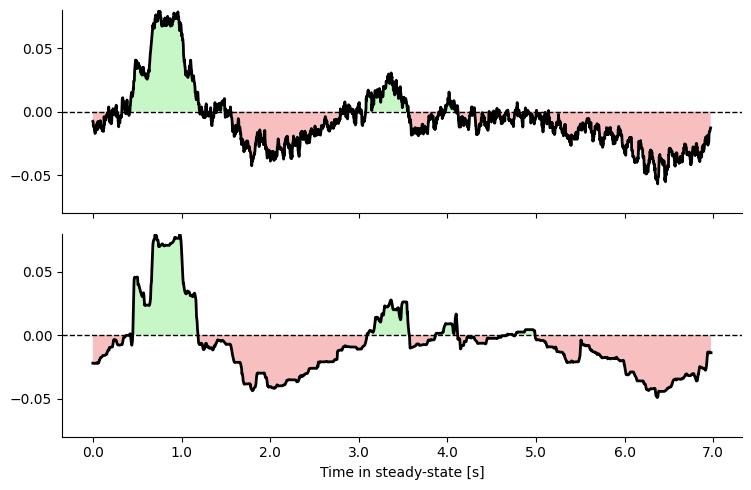

Saved comparison figure to figures/node_in_out_analysis/compare_P1_P2_RG50_node213_in_out_degree.svg


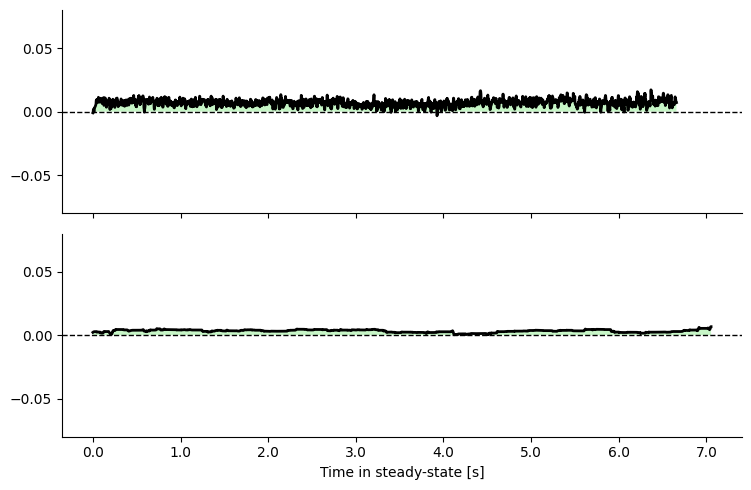

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def plot_node_in_out_degree(all_results, protocol='P1', RG=0, node_index=None, window_size=50, T_max=3900, figsize=(8, 2.5), save_dir=None):
    """
    Plot the difference between out-degree and in-degree for a specific node over time.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    protocol : str, default='P1'
        Protocol to visualize, either 'P1' or 'P2'
    RG : int, default=0
        Rotigaptide dose to analyze
    node_index : int, default=None
        Index of the node to analyze. If None, uses 213 for RG=50 and 220 for other doses.
    window_size : int, default=50
        Window size for the moving average smoothing
    T_max : int, default=3900
        Maximum time to consider
    figsize : tuple, default=(8, 2.5)
        Figure size
    save_dir : str or None, default=None
        Directory to save the figure, if None the filename is used directly
    """
    # Check if valid protocol
    if protocol not in ['P1', 'P2']:
        raise ValueError("Protocol must be either 'P1' or 'P2'")
    
    # Set default node index based on RG if not provided
    if node_index is None:
        node_index = 213 if RG == 50 else 220
    
    # Get results for the specified protocol and dose
    results = all_results[protocol][RG]
    first_alg_converged_status = results['first_alg_converged_status']
    matrices = np.stack(results['matrices'])
    Ws_steady = matrices[1:][first_alg_converged_status]
    vs = results['vertices']
    
    # Create color array for vertices
    cs = ['k'] * len(vs)
    cs[node_index] = 'r'
    
    # Visualize the node location
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(vs[:, 0], vs[:, 1], c=cs)
    ax.set_aspect('equal')
    ax.set_title(f'{protocol}, RG: {RG} μM, Node: {node_index}')
    
    if save_dir is not None:
        if os.path.isdir(save_dir):
            node_location_filename = os.path.join(save_dir, f'{protocol}_RG{RG}_node{node_index}_location.svg')
        else:
            dirname = os.path.dirname(save_dir)
            node_location_filename = os.path.join(dirname, f'{protocol}_RG{RG}_node{node_index}_location.svg')
        plt.savefig(node_location_filename, bbox_inches='tight', format='svg')
        print(f"Saved node location figure to {node_location_filename}")
    
    plt.show()
    plt.close()
    
    # Set up colormap and markers based on RG dose
    cmap = plt.get_cmap('Reds' if protocol == 'P1' else 'Blues')
    color = cmap((RG+20) / 100)
    
    markers = {0: 'v', 10: 'o', 30: 's', 50: 'D', 80: '^'}
    lmarker = markers.get(RG, 'o')
    lstyle = '-'
    
    # Create the main plot for in-out degree difference
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate out-degree minus in-degree
    out_in_diff = np.sum(Ws_steady[:, node_index, :], axis=1) - np.sum(Ws_steady[:, :, node_index], axis=1)
    
    # Smooth the data using a moving average
    if protocol == 'P1':
        smoothed_out_in_diff = np.convolve(out_in_diff, np.ones(window_size)/window_size, mode='same')
    else:
        smoothed_out_in_diff = out_in_diff
    
    # Plot the smoothed difference
    ax.plot(smoothed_out_in_diff, label='out - in (smoothed)', linewidth=2, color='k')
    
    # Highlight area between curve and 0
    plt.fill_between(np.arange(len(smoothed_out_in_diff)), smoothed_out_in_diff, 0, 
                     where=smoothed_out_in_diff > 0, facecolor='lightgreen', alpha=0.5)
    
    # Fill between 0 and the curve for negative values
    plt.fill_between(np.arange(len(smoothed_out_in_diff)), smoothed_out_in_diff, 0, 
                     where=smoothed_out_in_diff < 0, facecolor='lightcoral', alpha=0.5)
    
    plt.xlabel('Time in steady-state [s]')
    plt.ylabel('Out - In Degree')
    
    # Add protocol and node information
    plt.title(f'{protocol}, RG: {RG} μM, Node: {node_index}', fontsize=10)
    
    # Draw line along y=0
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    
    # Convert x scale to seconds where each 1 second == 395 iterations
    plt.xticks(np.arange(0, min(T_max-(2*395), len(smoothed_out_in_diff)), 395), 
               np.arange(0, min(T_max-(2*395), len(smoothed_out_in_diff))/395))
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-limits
    plt.ylim(-0.08, 0.08)
    
    # Save figure
    if save_dir is not None:
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, f'{protocol}_RG{RG}_node{node_index}_in_out_degree.svg')
        else:
            dirname = os.path.dirname(save_dir)
            filename = os.path.join(dirname, f'{protocol}_RG{RG}_node{node_index}_in_out_degree.svg')
        
        plt.savefig(filename, bbox_inches='tight', format='svg')
        print(f"Saved in-out degree figure to {filename}")
    
    plt.show()
    plt.close()

def compare_protocols_node_in_out_degree(all_results, RG=0, node_index=None, window_size=50, T_max=3900, figsize=(8, 5), save_dir=None):
    """
    Compare P1 and P2 protocols for a specific node's in-out degree difference.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    RG : int, default=0
        Rotigaptide dose to analyze
    node_index : int, default=None
        Index of the node to analyze. If None, uses 213 for RG=50 and 220 for other doses.
    window_size : int, default=50
        Window size for the moving average smoothing
    T_max : int, default=3900
        Maximum time to consider
    figsize : tuple, default=(8, 5)
        Figure size
    save_dir : str or None, default=None
        Directory to save the figure, if None the filename is used directly
    """
    # Set default node index based on RG if not provided
    if node_index is None:
        node_index = 213 if RG == 50 else 220
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Process each protocol
    for i, protocol in enumerate(['P1', 'P2']):
        ax = ax1 if protocol == 'P1' else ax2
        
        # Get results
        results = all_results[protocol][RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        Ws_steady = matrices[1:][first_alg_converged_status]
        
        # Set up colormap and markers based on RG dose and protocol
        cmap = plt.get_cmap('Reds' if protocol == 'P1' else 'Blues')
        color = cmap((RG+20) / 100)
        
        # Calculate out-degree minus in-degree
        out_in_diff = np.sum(Ws_steady[:, node_index, :], axis=1) - np.sum(Ws_steady[:, :, node_index], axis=1)
        
        # Smooth the data using a moving average
        if protocol == 'P1':
            smoothed_out_in_diff = np.convolve(out_in_diff, np.ones(window_size)/window_size, mode='same')
        else:
            smoothed_out_in_diff = out_in_diff

        # Plot the smoothed difference
        ax.plot(smoothed_out_in_diff, linewidth=2, color='k')
        
        # Highlight area between curve and 0
        ax.fill_between(np.arange(len(smoothed_out_in_diff)), smoothed_out_in_diff, 0, 
                       where=smoothed_out_in_diff > 0, facecolor='lightgreen', alpha=0.5)
        
        # Fill between 0 and the curve for negative values
        ax.fill_between(np.arange(len(smoothed_out_in_diff)), smoothed_out_in_diff, 0, 
                       where=smoothed_out_in_diff < 0, facecolor='lightcoral', alpha=0.5)
        
        # Draw line along y=0
        ax.axhline(0, color='black', linewidth=1, linestyle='--')
        
        # Set y-limits
        ax.set_ylim(-0.08, 0.08)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add protocol label to the right side
        # ax.text(1.02, 0.5, protocol, transform=ax.transAxes, 
        #         fontsize=12, fontweight='bold', 
        #         color='darkred' if protocol == 'P1' else 'darkblue',
        #         va='center')
    
    # Set common x-axis labels
    ax2.set_xlabel('Time in steady-state [s]')
    
    # Convert x scale to seconds where each 1 second == 395 iterations
    ax2.set_xticks(np.arange(0, T_max-(2*395), 395))
    ax2.set_xticklabels(np.arange(0, (T_max-(2*395))/395))

    # plot y labels only -0.05, 0, 0.05
    ax1.set_yticks([-0.05, 0, 0.05])
    ax2.set_yticks([-0.05, 0, 0.05])
    
    # Set y-axis label for both subplots
    # fig.text(0.04, 0.5, 'Out - In Degree', va='center', rotation='vertical')
    
    # Add title
    # fig.suptitle(f'RG: {RG} μM, Node: {node_index}', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, right=0.95, left=0.1)
    
    # Save figure
    if save_dir is not None:
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, f'compare_P1_P2_RG{RG}_node{node_index}_in_out_degree.svg')
        else:
            dirname = os.path.dirname(save_dir)
            filename = os.path.join(dirname, f'compare_P1_P2_RG{RG}_node{node_index}_in_out_degree.svg')
        
        plt.savefig(filename, bbox_inches='tight', format='svg')
        print(f"Saved comparison figure to {filename}")
    
    plt.show()
    plt.close()

# Example usage:
save_dir = 'figures/node_in_out_analysis'
os.makedirs(save_dir, exist_ok=True)

# For a single protocol analysis:
plot_node_in_out_degree(all_results, protocol='P1', RG=0, save_dir=save_dir, window_size=25)
plot_node_in_out_degree(all_results, protocol='P2', RG=0, save_dir=save_dir, window_size=25)

# For comparing protocols:
compare_protocols_node_in_out_degree(all_results, RG=0, save_dir=save_dir, window_size=25)
compare_protocols_node_in_out_degree(all_results, RG=50, save_dir=save_dir, window_size=25)

## Granger causality

In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR as VAR_model
from tqdm import tqdm
import gc
import pickle


def get_ar_data(signal, P):
    X = []
    y = []
    for t in range(P, len(signal)):
        xPt = np.stack([signal[t - p] for p in range(1, P+1)], axis=0)
        yt = signal[t]
        X.append(xPt)
        y.append(yt)
        
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)[:, :, None]
    return X, y


def node_wise_granger_causality(train_data, P, gc_test_mask=None):
    """
    Perform Granger causality testing using a node-wise approach, 
    training a separate VAR model for each target node.
    
    Parameters:
    -----------
    train_data : numpy.ndarray
        Time series data with shape (time_steps, variables)
    P : int
        Number of lags to include in the VAR model
    gc_test_mask : numpy.ndarray or None
        Binary mask indicating which node pairs to test for Granger causality.
        If None, all pairs will be tested.
        
    Returns:
    --------
    dict
        Dictionary containing the Granger causality weighted adjacency matrix 'W'
    """
    print('Running node-wise Granger causality testing...')
    
    # Ensure 2D data
    if train_data.ndim > 2:
        train_data = train_data[:, :, 0]
    
    N = train_data.shape[1]
    
    # If no mask is provided, test all pairs
    if gc_test_mask is None:
        gc_test_mask = np.ones((N, N), dtype=bool)
    
    # Initialize adjacency matrix
    W = np.zeros((N, N))
    
    # Process each node as a target
    for target_node in tqdm(range(N), desc="Processing target nodes"):
        # Find potential causal nodes from the mask
        potential_causes = [j for j in range(N) if gc_test_mask[target_node, j]]
        
        if not potential_causes:
            continue
        
        # Always include the target node in the model
        if target_node not in potential_causes:
            model_nodes = [target_node] + potential_causes
        else:
            model_nodes = potential_causes.copy()
        
        # Create subset dataframe for this specific node's model
        column_names = [f'var_{i}' for i in model_nodes]
        df_subset = pd.DataFrame(train_data[:, model_nodes], columns=column_names)
        
        try:
            # Fit VAR model on the subset
            model = VAR_model(df_subset)
            results = model.fit(P)
            
            # Test Granger causality for each potential cause
            for cause_node in potential_causes:
                if target_node == cause_node:
                    continue  # Skip self-causality
                
                try:
                    # Find the indices of the target and cause in the subset model
                    target_col = f'var_{target_node}'
                    cause_col = f'var_{cause_node}'
                    
                    # Test causality
                    causality_test = results.test_causality(target_col, cause_col, kind='f')
                    p_value = causality_test.pvalue
                    
                    # If significant, compute the weight
                    if p_value < 0.05:
                        # Find the index of the target and cause in the model
                        target_idx = column_names.index(target_col)
                        cause_idx = column_names.index(cause_col)
                        
                        # Extract coefficients
                        coefs = np.array([results.coefs[lag][target_idx, cause_idx] for lag in range(P)])
                        
                        # Use the norm of coefficients as the weight
                        W[target_node, cause_node] = np.linalg.norm(coefs)
                    
                    # Clear memory
                    del causality_test
                    
                except Exception as e:
                    print(f"Error testing causality from {cause_node} to {target_node}: {e}")
            
            # Clear memory
            del results
            del model
            
        except Exception as e:
            print(f"Error fitting VAR model for target node {target_node}: {e}")
        
        # Force garbage collection
        gc.collect()
    
    print('Node-wise Granger causality testing completed.')
    return {'W': W}

hyperparams = {'P': 3}
granger_results = {}
for RG in [0, 10, 30, 50, 80]:
    optical_path = f'data/RG_analysis_data/09_04_18/RG{RG}_10s.pkl'

    with open(optical_path, 'rb') as f:
        data = pickle.load(f)
        videos = optical_data_preprocessing([data])
        videos = downsample_videos(videos, 1, 4)
        videos = crop_videos_to_heart(videos)
        videos = [mean_std_norm(video, axis=0) for video in videos]

    all_vertices = get_vertices_without_nans(videos)
    conn = get_connectivity(all_vertices)[0]
    signal = get_signals(all_vertices, videos)[0]
    _, y = get_ar_data(signal, hyperparams['P'])
    
    # run node-wise Granger causality
    model_inputs = {
        'train_data': y,
        'P': hyperparams['P'],
        'gc_test_mask': conn,
    }

    fname = optical_path.split('/')[-1].split('.')[0]
    fpath = '/'.join(optical_path.split('/')[:-1])
    fsave_name = f"{fpath}/{fname}_results_nodewise_granger.pkl"

    try:
        with open(fsave_name, 'rb') as f:
            results = pickle.load(f)
    except FileNotFoundError:
        results = node_wise_granger_causality(**model_inputs)
        with open(fsave_name, 'wb') as f:
            pickle.dump(results, f)

    results['signal'] = signal
    results['vertices'] = all_vertices[0]
    granger_results[RG] = results

/home/ajenkins/Projects/Adaptive/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))


Running node-wise Granger causality testing...


Processing target nodes: 100%|██████████| 315/315 [00:39<00:00,  8.00it/s]


Node-wise Granger causality testing completed.


/home/ajenkins/Projects/Adaptive/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))


Running node-wise Granger causality testing...


Processing target nodes: 100%|██████████| 311/311 [00:39<00:00,  7.87it/s]

Node-wise Granger causality testing completed.


Saved figure to figures/granger_causality/granger_causality.svg


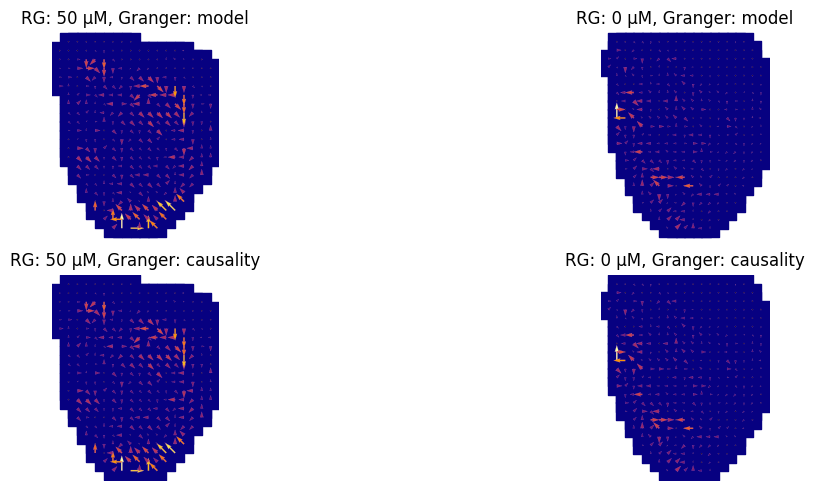

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_net_flow(W, verts):
    n = W.shape[0]
    net_flow = np.zeros((n, 2))
    
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                if i != j:
                    direction = verts[j] - verts[i]
                    direction /= np.linalg.norm(direction)
                    net_flow[i] += direction * (W[i, j] - W[j, i])
        
    return net_flow

def plot_granger_causality(granger_results, figsize=(15, 5), save_dir=None):
    """
    Plot the Granger causality network visualization.
    
    Parameters:
    -----------
    granger_results : dict
        Dictionary containing Granger causality results for different doses
    figsize : tuple, default=(15, 5)
        Figure size
    save_dir : str, default=None
        Directory to save the figure, if None the figure is not saved
    """
    # Only use RG=0 and RG=50, in the same order as other plots
    rotigaptide_doses = [50, 0]
    
    # Create a 2x2 figure to match the two_timepoints layout
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    cmap = plt.cm.inferno

    for idx, RG in enumerate(rotigaptide_doses):
        results = granger_results[RG]
        verts = results['vertices'].astype(float)
        
        # Get the Granger causality matrix
        W = results['W']

        # Create two identical plots for this dose (to match the two_timepoints layout)
        for row in range(2):
            ax = axes[row, idx]
            
            # Remove self-loops and keep only the strongest edge for each node
            np.fill_diagonal(W, 0)
            W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

            # Compute net flow
            net_flow = compute_net_flow(W, verts)
            
            # Normalize net flow for better visualization
            net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
            max_magnitude = np.max(net_flow_magnitude)
            net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

            # Create quiver plot with exact same styling
            ax.scatter(verts[:, 0], verts[:, 1], c='#070181', s=160, marker='s', alpha=1)
            ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                      net_flow_magnitude, cmap=cmap, scale=11, width=0.008, edgecolors='orchid', linewidths=0.1)

            # Plot settings
            ax.set_aspect('equal')
            time_label = "model" if row == 0 else "causality"  # Use different labels for the two rows
            ax.set_title(f'RG: {RG} µM, Granger: {time_label}')
            ax.axis('off')

    plt.tight_layout()
    if save_dir is not None:
        # Create filename
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, f'granger_causality.svg')
        else:
            # Add prefix to the filename
            dirname = os.path.dirname(save_dir)
            basename = os.path.basename(save_dir)
            filename = os.path.join(dirname, f'granger_{basename}')
        
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved figure to {filename}")
    
    plt.show()
    plt.close()

# Usage examples:
save_dir = 'figures/granger_causality'
os.makedirs(save_dir, exist_ok=True)
plot_granger_causality(granger_results, save_dir=save_dir)

Saved figure to figures/frob_norm_analysis/frob_norm_vs_granger_multi_dose.svg


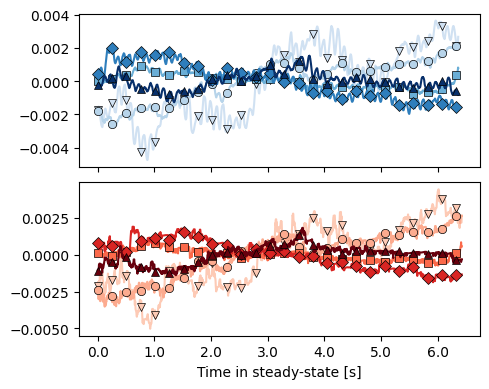

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_frobenius_norm_multi_dose(all_results, granger_results, figsize=(5, 4), T_max=3900, save_dir=None, window_size=25):
    """
    Plot time series of the Frobenius norm difference for multiple doses on the same plot.
    P1 on top row, P2 on bottom row.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for both protocols
    granger_results : dict
        Dictionary containing Granger causality results
    figsize : tuple, default=(10, 6)
        Figure size
    T_max : int, default=3900
        Maximum time to consider
    save_dir : str or None, default=None
        Directory to save the figure, if None the filename is used directly
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Define doses to plot
    rotigaptide_doses = [0, 10, 30, 50, 80]
    
    # Define markers for different doses
    markers = {0: 'v', 10: 'o', 30: 's', 50: 'D', 80: '^'}
    
    # Define colormap for different doses
    cmap_p1 = plt.get_cmap('Blues')
    cmap_p2 = plt.get_cmap('Reds')
    
    # Find the shortest time series length across all datasets for proper comparison
    min_length = float('inf')
    for protocol in ['P1', 'P2']:
        for RG in rotigaptide_doses:
            results = all_results[protocol][RG]
            first_alg_converged_status = results['first_alg_converged_status']
            matrices = np.stack(results['matrices'])
            Ws_steady = matrices[1:][first_alg_converged_status]
            min_length = min(min_length, len(Ws_steady))
    
    min_length = min(min_length, T_max)
    
    # Process each protocol
    for protocol_idx, protocol in enumerate(['P1', 'P2']):
        ax = ax1 if protocol == 'P1' else ax2
        
        # Plot each dose
        for RG in rotigaptide_doses:
            # Get the Granger matrix for this RG dose
            W_granger = granger_results[RG]['W']

            # Get results
            results = all_results[protocol][RG]
            first_alg_converged_status = results['first_alg_converged_status']
            matrices = np.stack(results['matrices'])
            Ws_steady = matrices[1:][first_alg_converged_status]
            
            # Set up color based on dose and protocol
            if protocol == 'P1':
                color_intensity = (RG + 20) / 100
                color = cmap_p1(color_intensity)
            else:
                color_intensity = (RG + 20) / 100
                color = cmap_p2(color_intensity)
            
            # Calculate Frobenius norm of difference for each time point
            frob_norm_diffs = []
            for W_t in Ws_steady[:min_length]:
                # Calculate W_t - W_granger
                diff_matrix = W_t - W_granger
                # Calculate Frobenius norm: sqrt(sum of squared elements)
                frob_norm = np.linalg.norm(diff_matrix, 'fro') / np.linalg.norm(W_granger, 'fro')
                frob_norm_diffs.append(frob_norm)
            
            if protocol == 'P1':
                frob_norm_diffs = np.convolve(frob_norm_diffs, np.ones(window_size)/window_size, mode='same')
                frob_norm_diffs = frob_norm_diffs[window_size//2:-window_size//2]
            else:
                frob_norm_diffs = frob_norm_diffs
            frob_norm_diffs = np.array(frob_norm_diffs)
            frob_norm_diffs -= np.mean(frob_norm_diffs)
            
            # Plot the time series with appropriate marker for dose
            ax.plot(frob_norm_diffs, linewidth=1.5, color=color, 
                   label=f'RG: {RG} μM', marker=markers[RG], markevery=100, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
        
        # Add protocol-specific styling
        # ax.set_ylabel(f'{protocol}\n$\\Vert W(t) - W_{{granger}} \\Vert_F$', fontsize=10)
        
        # Remove top and right spines
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        
        # Add grid
        # ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend
        # if protocol == 'P1':
        #     ax.legend(loc='upper right', ncol=len(rotigaptide_doses), frameon=True, 
        #               fancybox=True, framealpha=0.8)
    
    # Set common x-axis labels
    ax2.set_xlabel('Time in steady-state [s]')
    
    # Convert x scale to seconds where each 1 second == 395 iterations
    ax2.set_xticks(np.arange(0, min(min_length, T_max-(2*395)), 395))
    ax2.set_xticklabels(np.arange(0, min(min_length, T_max-(2*395))/395))
    
    # Add title
    # plt.suptitle('Frobenius Norm Difference with Granger Across Doses', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    
    # Save figure
    if save_dir is not None:
        if os.path.isdir(save_dir):
            filename = os.path.join(save_dir, 'frob_norm_vs_granger_multi_dose.svg')
        else:
            dirname = os.path.dirname(save_dir)
            filename = os.path.join(dirname, 'frob_norm_vs_granger_multi_dose.svg')
        
        plt.savefig(filename, bbox_inches='tight', format='svg')
        print(f"Saved figure to {filename}")
    
    plt.show()
    plt.close()

save_dir = 'figures/frob_norm_analysis'
os.makedirs(save_dir, exist_ok=True)
plot_frobenius_norm_multi_dose(all_results, granger_results, save_dir=save_dir)